## Comparing Classifiers: Wine Variety Prediction

### Chi-Chun Lu

### 03/20/2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from itertools import count
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

## Get the data

In [2]:
df = pd.read_csv("wine_data.csv", header = None)
df.columns = ["case", "Alcohol", "MalicAcid", "Ash", "AlcalinityOfAsh", "Magnesium", "TotalPhenols", 
              "Flavanoids", "NonflavanoidPhenols", "Proanthocyanins", "ColorIntensity", "Hue", 
              "OD280_OD315", "Proline"]

In [3]:
df.head()

,case,Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,Flavanoids,NonflavanoidPhenols,Proanthocyanins,ColorIntensity,Hue,OD280_OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Preliminary Data Analysis

In [4]:
df.groupby("case").size()

case
1    59
2    71
3    48
dtype: int64

There as three cases and the amounts of each case are shown above.

### Check for Outliners

There are 11 outliners (178 - 167) but they may be not noise so they do not be romoved.

In [5]:
from scipy import stats

df[(np.abs(stats.zscore(df)) < 3).all(axis=1)].count()

case                   168
Alcohol                168
MalicAcid              168
Ash                    168
AlcalinityOfAsh        168
Magnesium              168
TotalPhenols           168
Flavanoids             168
NonflavanoidPhenols    168
Proanthocyanins        168
ColorIntensity         168
Hue                    168
OD280_OD315            168
Proline                168
dtype: int64

### Check for Missing Values

No missing values.

In [6]:
df.isnull().sum()

case                   0
Alcohol                0
MalicAcid              0
Ash                    0
AlcalinityOfAsh        0
Magnesium              0
TotalPhenols           0
Flavanoids             0
NonflavanoidPhenols    0
Proanthocyanins        0
ColorIntensity         0
Hue                    0
OD280_OD315            0
Proline                0
dtype: int64

### Attribute Correlations

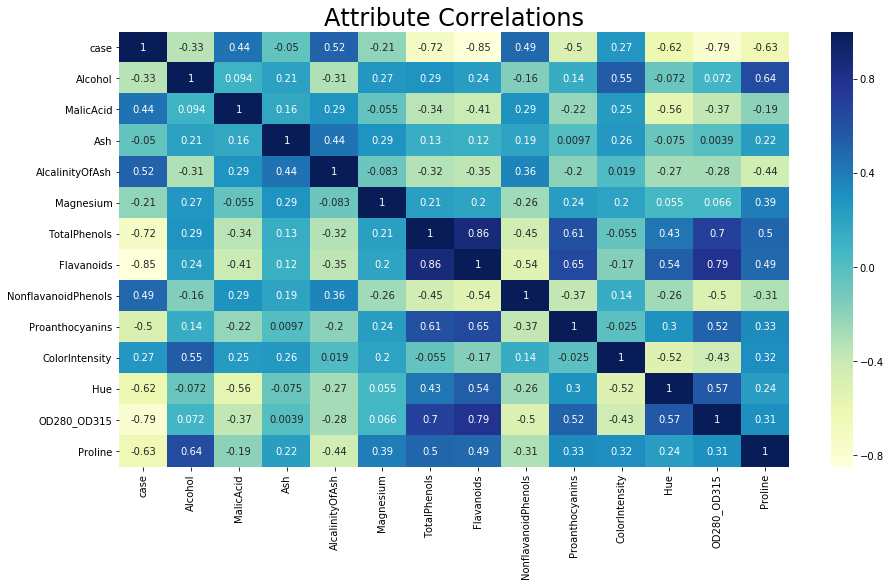

In [7]:
plt.figure(figsize = (15, 8))

attributeCorrelations = df[df.columns].corr()
sns.heatmap(attributeCorrelations, cmap="YlGnBu", annot = True)

plt.title("Attribute Correlations", fontsize = 24)

plt.show()

According to this Attribute Correlations figure shown above, among all attributes, "Ash" has the least correlations with other attributes so it could be ignored in following steps.

In [8]:
import heapq

absSumOfAttributeCorrelations = attributeCorrelations[attributeCorrelations.columns].abs().sum()

print('Abosulate Summary of Attribute Correlations:', '\nAtrribute             Abs Summary')
print(absSumOfAttributeCorrelations)

Abosulate Summary of Attribute Correlations: 
Atrribute             Abs Summary
case                   7.402563
Alcohol                4.367915
MalicAcid              4.670193
Ash                    3.156218
AlcalinityOfAsh        4.885079
Magnesium              3.522095
TotalPhenols           6.621719
Flavanoids             7.209950
NonflavanoidPhenols    5.312493
Proanthocyanins        5.101221
ColorIntensity         4.197137
Hue                    5.513241
OD280_OD315            6.392491
Proline                6.026176
dtype: float64


To ensure our dropping action, the Abosulate Summary of Attribute Correlations, a abosulate summary of correlations for each attribute with others, also be calculated to support that "Ash" is the least one.

Top 5 correlations excluding "case" are "Flavanoids", "TotalPhenols", "OD280_OD315", "Proline" and "Hue".

<Figure size 1152x576 with 0 Axes>

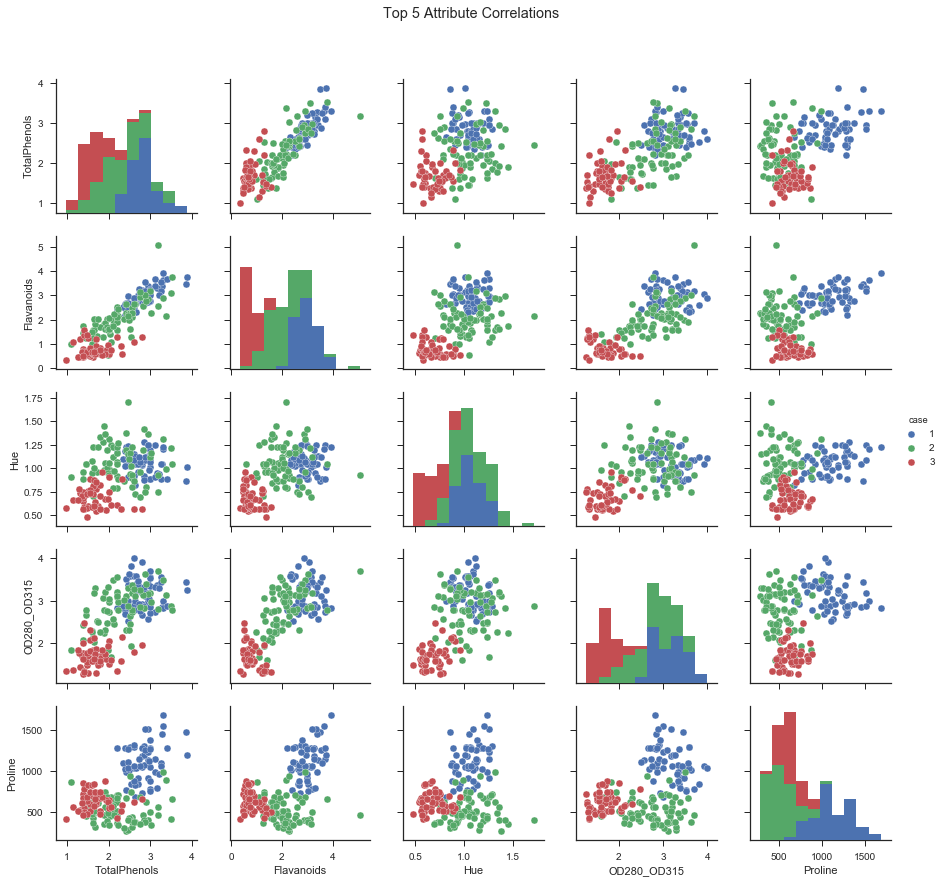

In [9]:
plt.figure(figsize = (16, 8))

sns.set(style="ticks", color_codes=True)
sns.pairplot(df, hue="case", vars=["TotalPhenols", "Flavanoids", "Hue", "OD280_OD315", "Proline"])

plt.subplots_adjust(top=0.9)
plt.suptitle("Top 5 Attribute Correlations")

plt.show()

According to Top5 attribute correlations charts shown above, we found that some attributes has strong correlations with case:

| Attribute                    | Description                                              |
|:---------                    | :-------------                                           |
|"TotalPhenols"                | Most wine with case 3 has lower value of "Flavanoids"    |
|"Flavanoids"                  | Wine with case 3 has lower value of "Flavanoids"         |
|"Hue"                         | Wine with case 3 has lower value of "Hue"                |
|"OD280_OD315"                 | Wine with case 3 has lower value of "OD280_OD315"        |
|"Proline"                     | Wine with case 1 obviously has higher value of "Proline  |

<Figure size 1440x432 with 0 Axes>

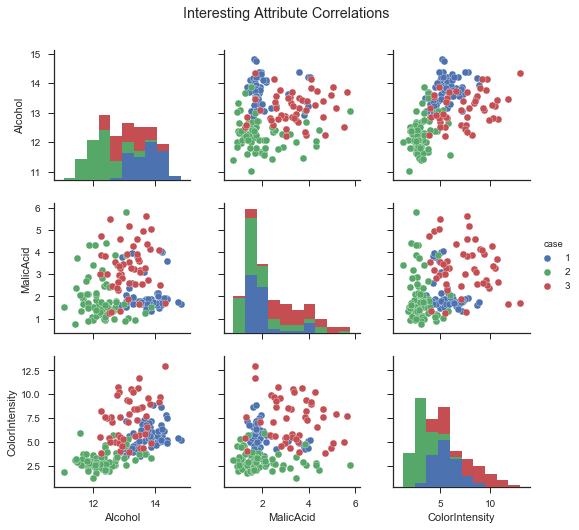

In [10]:
plt.figure(figsize = (20, 6))

sns.set(style="ticks", color_codes=True)
sns.pairplot(df, hue="case", vars=["Alcohol", "MalicAcid", "ColorIntensity"], size=2.5)

plt.subplots_adjust(top=0.9)
plt.suptitle('Interesting Attribute Correlations')

plt.show()

According to Interesting Attribute Correlations:

| Attribute                    | Description                                          |
|:---------                    | :-------------                                       |
|"Alcohol"                     | Wine with case 2 has lower value of "Alcohol"        |
|"MalicAcid"                   | Wine with case 1 has lower value of "MalicAcid"      |
|"ColorIntensity"              | Wine with case 2 has lower value of "ColorIntensity" |

### Summary Statistics

In [11]:
df.describe()

,case,Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,Flavanoids,NonflavanoidPhenols,Proanthocyanins,ColorIntensity,Hue,OD280_OD315,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


According to the table of summary statistics, "Proline" has largest std and from attribute correlation chart, it has a strong correlation with case. That is, case 1 has higher "Proline" value.

## Data Preprocessing 

### Drop Attritbute

In [12]:
dfX = df.drop(['case','Ash'], axis = 1)
dfX.head()

,Alcohol,MalicAcid,AlcalinityOfAsh,Magnesium,TotalPhenols,Flavanoids,NonflavanoidPhenols,Proanthocyanins,ColorIntensity,Hue,OD280_OD315,Proline
0,14.23,1.71,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


"case" and "Ash" is dropped because "Ash" has the least correlation and "case" is label.

In [13]:
dfY = df.iloc[:,:1]
cases = dfY.case.unique()
casesNum = len(cases)
cases

array([1, 2, 3])

There are three cases.

### Convert Data Frame to Array

In [14]:
Y = dfY.values

Just convert dfY becasue dfX will be converted in the step of normalization.

### Normalize

In [15]:
normalizedX = preprocessing.normalize(dfX, norm='l2')
normalizedX

array([[1.32645064e-02, 1.59397793e-03, 1.45415530e-02, ...,
        9.69436870e-04, 3.65403128e-03, 9.92740641e-01],
       [1.25128262e-02, 1.68733566e-03, 1.06169435e-02, ...,
        9.95338449e-04, 3.22300069e-03, 9.95338449e-01],
       [1.10630414e-02, 1.98394967e-03, 1.56362135e-02, ...,
        8.65876339e-04, 2.66488155e-03, 9.96178119e-01],
       ...,
       [1.57228013e-02, 5.07110697e-03, 2.36967616e-02, ...,
        6.99054466e-04, 1.84834740e-03, 9.89339795e-01],
       [1.55137210e-02, 3.05091401e-03, 2.35591815e-02, ...,
        7.06775446e-04, 1.90829370e-03, 9.89485624e-01],
       [2.48343366e-02, 7.20600000e-03, 4.30602439e-02, ...,
        1.07211220e-03, 2.81209756e-03, 9.84234146e-01]])

Normalized values of attributes because some of attributes such as "Proline" have large value.

## Choose an Evaluation Approach

### Split Data

In [16]:
trainingX, validationX, trainingY, validationY = train_test_split(normalizedX, Y, test_size=0.3, random_state=0)

trainingSize = trainingX.shape[0]
attributesNumTraining = trainingX.shape[1]

validationSize = validationX.shape[0]
attributesNumValidation = validationX.shape[1]


print("Training Size:", trainingSize, "\nAttribute Number of Training:", attributesNumTraining)
print("\nValidation Size:", validationSize, "\nAttribute Number of Validation:", attributesNumValidation)

Training Size: 124 
Attribute Number of Training: 12

Validation Size: 54 
Attribute Number of Validation: 12


Data set is splitted into Training set which is 70% and validation set which is 30% by holdout.

In [17]:
trainX, testX, trainY, testY = train_test_split(trainingX, trainingY, test_size=0.3, random_state=0)

trainSize = trainX.shape[0]
attributesNumTrain = trainX.shape[1]

testSize = testX.shape[0]
attributesNumTest = testX.shape[1]

print("Train Size:", trainSize, "\nAttribute Number of Train:", attributesNumTrain)
print("\ntest Size:", testSize, "\nAttribute Number of Test:", attributesNumTest)

Train Size: 86 
Attribute Number of Train: 12

test Size: 38 
Attribute Number of Test: 12


Following, training set is splitted into train set which is 70% and test set which is 30% for part 4.

The holdout mehtod is used here because it is a convenient way to split data set although it may estimate the performance of model misleadingly if a bad split occurs.

## Build and Evaluate Six Classifiers 

### k-Nearest Neighbors

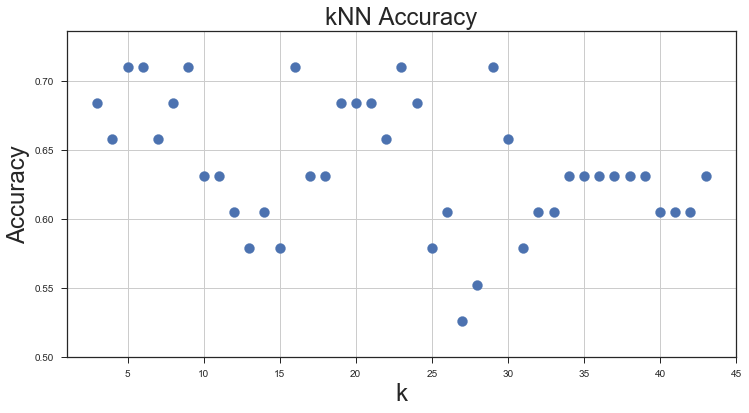

k with max accuray: 5 
Max accuracy: 0.7105263157894737

Precision: 0.7142857142857143 
Recall: 0.7516025641025642 
F1 score: 0.7324691550835547


In [18]:
# accuracy for each k
knnAccuracies = []

# k range
K = np.arange(3, round(0.5 * trainX.shape[0]) + 1)
 
for k in K:
    knnClf = KNeighborsClassifier(n_neighbors = k)
    wineKnnClf = knnClf.fit(trainX, trainY.ravel())
    predictedTestY = wineKnnClf.predict(testX)
    score = accuracy_score(testY, predictedTestY)
    knnAccuracies.append(score)

# plt
plt.figure(figsize = (12, 6))
plt.scatter(K, knnAccuracies, s = 100)

plt.title("kNN Accuracy", fontsize = 24)
plt.xlabel("k", fontsize = 24)
plt.ylabel("Accuracy", fontsize = 24)

plt.grid(True)
plt.show()

# accuracy
maxk = knnAccuracies.index(max(knnAccuracies)) + 3
maxAccuracy = max(knnAccuracies)
print("k with max accuray:", maxk, "\nMax accuracy:", maxAccuracy)

# k =5
knnClf = KNeighborsClassifier(n_neighbors = 5)
wineKnnClf = knnClf.fit(trainX, trainY.ravel())
predictedTestY = wineKnnClf.predict(testX)

# f-measure
precision = precision_score(testY, predictedTestY, average='macro')
recall = recall_score(testY, predictedTestY, average='macro')
F1Score = 2 / ((1 / precision) + (1 / recall))
print("\nPrecision:", precision,"\nRecall:", recall, "\nF1 score:", F1Score)

K's range is from 3 to 44 and when k = 5, 6, 9, 16, 23 or 29, acuuracy can reach its maximum value, 0.7105. 

For Parameters:


| Parameters  | Set                  | Description                            |
|:---------   | :-------------       |:-------------                          |
|n_neighbors  | from 3 to 44         | Number of neighbors                    |
|weights      | default              | Weight function                        |
|algorithm    | default              | Method To compute the nearest neighbors|
|leaf_size    | default = 30         | Leaf size (BallTree or KDTree)         |
|p            | default = 2          | Power parameter (Minkowski metric)     |
|metric       | default = "minkowski"| Distance metric                        |
|metric_params| default = None       | Additional arguments (metric)          |
|n_jobs       | default = 30         | Number of parallel jobs                | 
|             |                      | Reference: http://scikit-learn.org/    |

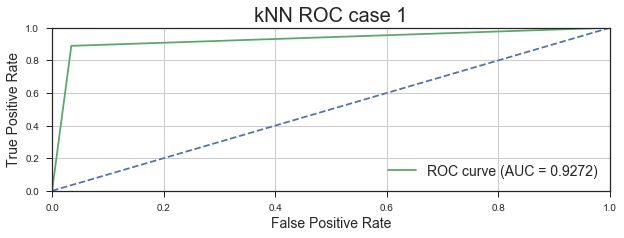

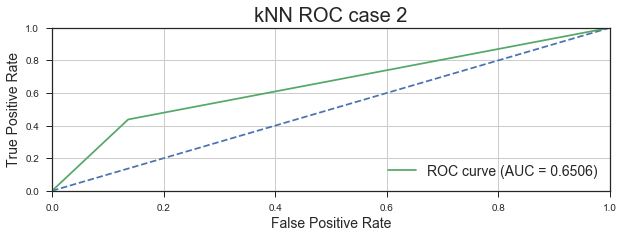

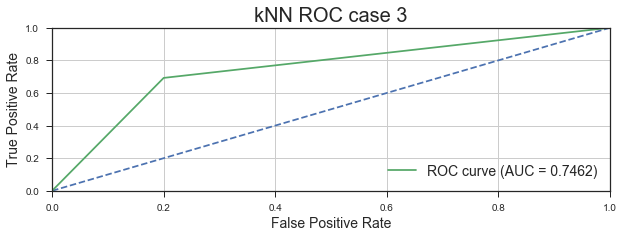

In [19]:
X = trainingX

# binarize
Y = label_binarize(trainingY, classes=[1, 2, 3])

# split data
trainXROC, testXROC, trainYROC, testYROC = train_test_split(X, Y, test_size=0.3, random_state=0)

# kNN classifier
classifier = KNeighborsClassifier(n_neighbors = 5)
predictedYROC = classifier.fit(trainXROC, trainYROC).predict(testXROC)

# ROC curve and AUC
falsePositiveR = dict()
truePositiveR = dict()
AUC = dict()

for i in range(3):
    falsePositiveR[i], truePositiveR[i], _ = roc_curve(testYROC[:, i], predictedYROC[:, i])
    AUC[i] = auc(falsePositiveR[i], truePositiveR[i])

# Plot
for i in range(3):
    plt.figure(figsize = (10, 3))
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(falsePositiveR[i], truePositiveR[i], label='ROC curve (AUC = %0.4f)' % AUC[i])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.title('kNN ROC case %d' %(i+1), fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.legend(loc="lower right", fontsize = 14)
    
    plt.grid(True)
    plt.show()

To get ROC curve and AUC, case (Y) has been binarized.

ROC curves and AUCs for each case are shown above. 

### kNN Summary

| Evaluate     | Value                               |
|:---------    | :-------------                      |
|Accuracy      | 0.7105 when k = 5, 6, 9, 16, 23, 29 |
|Precision     | 0.7142                              |
|Recall        | 0.7516                              |
|F1 score      | 0.7324                              |
|Case 1 AUC    | 0.9272                              |
|Case 2 AUC    | 0.6506                              |
|Case 3 AUC    | 0.7462                              |

### Decision Tree 

In [20]:
# Use Gini
DecisionTreeGini = DecisionTreeClassifier(criterion='gini', random_state=0)
DecisionTreeGini.fit(trainX, trainY)
predYTreeGini = DecisionTreeGini.predict(testX)
accuracyTreeGini = accuracy_score(testY, predYTreeGini)

# Use Entropy
DecisionTreeEntropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
DecisionTreeEntropy.fit(trainX, trainY)
predYTreeEntropy = DecisionTreeEntropy.predict(testX)
accuracyTreeEntropy = accuracy_score(testY, predYTreeEntropy)

# f-measure
precisionTree = precision_score(testY, predYTreeGini, average='macro')
recallTree = recall_score(testY, predYTreeGini, average='macro')
F1ScoreTree = 2 / ((1 / precisionTree) + (1 / recallTree))

print("Accuracy of Decision Tree with Gini: %0.4f" % accuracyTreeGini)
print("Accuracy of Decision Tree with Entropy: %0.4f" % accuracyTreeEntropy)
print("\nF-measure for Tree with Gini:")
print("Precision:", precisionTree,"\nRecall:", recallTree, "\nF1 score:", F1ScoreTree)

Accuracy of Decision Tree with Gini: 0.8947
Accuracy of Decision Tree with Entropy: 0.8158

F-measure for Tree with Gini:
Precision: 0.8952380952380953 
Recall: 0.9118589743589745 
F1 score: 0.9034720990532176


Accuracy for Decision Tree with Gini and with Entropy:

| criterion | Accuracy        | 
|:--------- | :-------------  |
|Gini       | 0.8947          |
|Entropy    | 0.8158          |

For Parameters:

| Parameters                | Set              | Description                                     |
|:---------                 | :-------------   |:-------------                                   |
|criterion                  | Gini; Entropy    | Measure a split quality                         |
|splitter                   | default = ”best” | Method to choose a split for each node          |
|max_depth                  | default = None   | Maximum depth                                   |
|min_samples_split          | default = 2      | Minimum number of samples (internal node)       |
|min_samples_leaf           | default = 1      | Minimum number of samples (leaf node)           |
|min_weight_fraction_leaf   | default = 0      | Minimum weighted / total of weights (leaf node) |
|max_features               | default = None   | Number of features for the best split           |
|random_state               | 0                | Random number generator                         | 
|max_leaf_nodes             | default = None   | Number of leaf nodes                            | 
|min_impurity_decrease      | default = 0      | Minimum impurity decrease to be split           | 
|min_impurity_split         | Deprecated       |  Use min_impurity_decrease                      | 
|class_weight               | default = None   | Weights of classes                              | 
|presort                    | default = False  | whether presort or not                          |
|                           |                  | Reference: http://scikit-learn.org/             |

For F-measure:

| Evaluate  | Value   | 
|:--------- | :------ |
|Precision  | 0.8952  |
|Recall     | 0.9118  |
|F1 score   | 0.9034  |


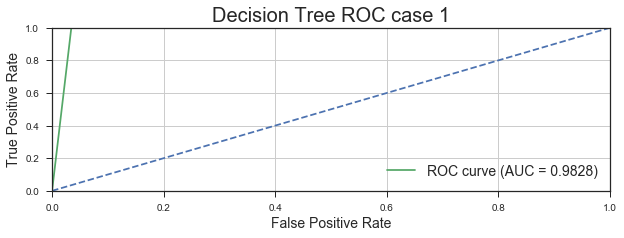

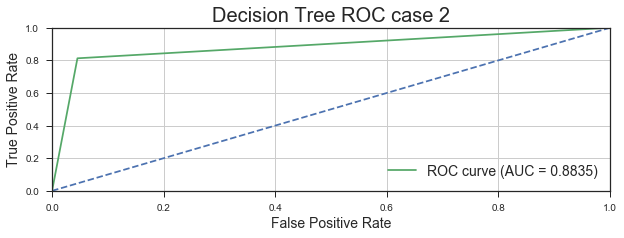

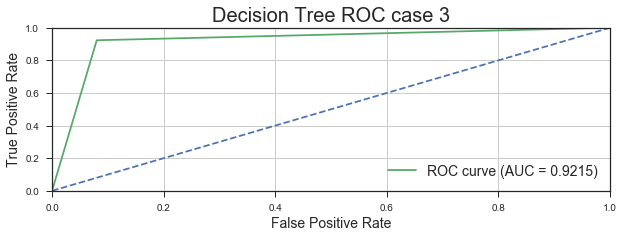

In [21]:
X = trainingX

# binarize
Y = label_binarize(trainingY, classes=[1, 2, 3])

# split data
trainXROC, testXROC, trainYROC, testYROC = train_test_split(X, Y, test_size=0.3, random_state=0)

# Decision Tree classifier
classifierTree = DecisionTreeClassifier(criterion='gini', random_state=0)
predictedYTreeROC = classifierTree.fit(trainXROC, trainYROC).predict(testXROC)

# ROC curve and AUC
falsePositiveRDT = dict()
truePositiveRDT = dict()
AUC = dict()

for i in range(3):
    falsePositiveRDT[i], truePositiveRDT[i], _ = roc_curve(testYROC[:, i], predictedYTreeROC[:, i])
    AUC[i] = auc(falsePositiveRDT[i], truePositiveRDT[i])

# Plot
for i in range(3):
    plt.figure(figsize = (10, 3))
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(falsePositiveRDT[i], truePositiveRDT[i], label='ROC curve (AUC = %0.4f)' % AUC[i])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.title('Decision Tree ROC case %d' %(i+1), fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.legend(loc="lower right", fontsize = 14)
    
    plt.grid(True)
    plt.show()

ROC curve and AUC for each case are shown above.

### Decision Tree Summary

| Evaluate     | Value                                   |
|:---------    | :-------------                          |
|Accuracy      | With Gini: 0.8947; with Entropy: 0.8158 |
|Precision     | 0.8952                                  |
|Recall        | 0.9118                                  |
|F1 score      | 0.9034                                  |
|Case 1 AUC    | 0.9828                                  |
|Case 2 AUC    | 0.8835                                  |
|Case 3 AUC    | 0.9215                                  |

### Naïve Bayes

In [22]:
NBClf = GaussianNB(priors=None)
NBClf.fit(trainX, trainY.ravel())
predYNB = NBClf.predict(testX)
accuracyNB = accuracy_score(testY, predYNB)

# f-measure
precisionNB = precision_score(testY, predYNB, average='macro')
recallNB = recall_score(testY, predYNB, average='macro')
F1ScoreNB = 2 / ((1 / precisionNB) + (1 / recallNB))

print("Accuracy of Naïve Bayes: %0.4f" % accuracyNB)
print("\nF-measure for Naïve Bayes:")
print("Precision:", precisionNB,"\nRecall:", recallNB, "\nF1 score:", F1ScoreNB)

Accuracy of Naïve Bayes: 0.8947

F-measure for Naïve Bayes:
Precision: 0.8857142857142858 
Recall: 0.9004629629629629 
F1 score: 0.8930277335505609


Accuracy of Naïve Bayes:

| classifier | Accuracy        | 
|:---------  | :-------------  |
|Naïve Bayes | 0.8947          |

For Parameters:

| Parameters | Set    | Description                         |
|:---------  | :----- |:-------------                       |
|priors      | None   | Prior probabilities                 |
|            |        | Reference: http://scikit-learn.org/ |

For F-measure:

| Evaluate  | Value   | 
|:--------- | :------ |
|Precision  | 0.8857  |
|Recall     | 0.9004  |
|F1 score   | 0.8930  |

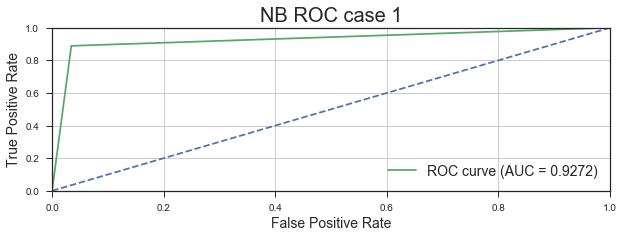

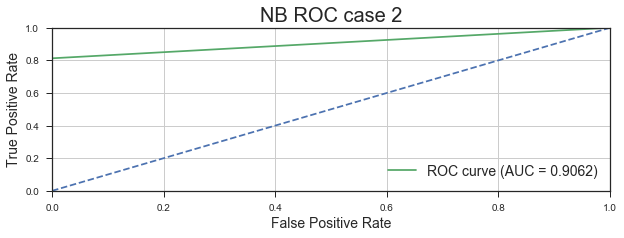

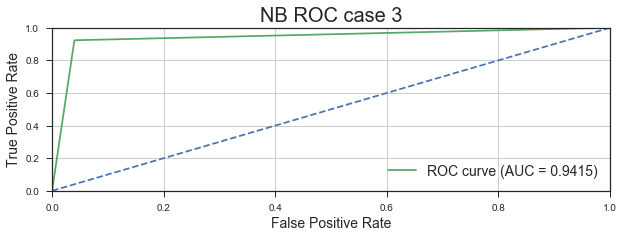

In [23]:
X = trainingX

# binarize
Y = label_binarize(trainingY, classes=[1, 2, 3])

# split data
trainXROC, testXROC, trainYROC, testYROC = train_test_split(X, Y, test_size=0.3, random_state=0)


# Naïve Bayes classifier
classifierNB = GaussianNB(priors=None)

predictedYNBROC = dict()

for i in range(3):
    predictedYNBROC[i] = classifierNB.fit(trainXROC, trainYROC[:, i]).predict(testX)

# ROC curve and AUC
falsePositiveRNB = dict()
truePositiveRNB = dict()
AUC = dict()

for i in range(3):
    falsePositiveRNB[i], truePositiveRNB[i], _ = roc_curve(testYROC[:, i], predictedYNBROC[i])


for i in range(3):
    AUC[i] = auc(falsePositiveRNB[i], truePositiveRNB[i])

# Plot
for i in range(3):
    plt.figure(figsize = (10, 3))
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(falsePositiveRNB[i], truePositiveRNB[i], label='ROC curve (AUC = %0.4f)' % AUC[i])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.title('NB ROC case %d' %(i+1), fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.legend(loc="lower right", fontsize = 14)
    
    plt.grid(True)
    plt.show()

ROC curve and AUC for each case are shown above.

### Naïve Bayes Summary

| Evaluate     | Value                                   |
|:---------    | :-------------                          |
|Accuracy      | 0.8947                                  |
|Precision     | 0.8857                                  |
|Recall        | 0.9004                                  |
|F1 score      | 0.8930                                  |
|Case 1 AUC    | 0.9272                                  |
|Case 2 AUC    | 0.9062                                  |
|Case 3 AUC    | 0.9415                                  |

### Artificial Neural Network 

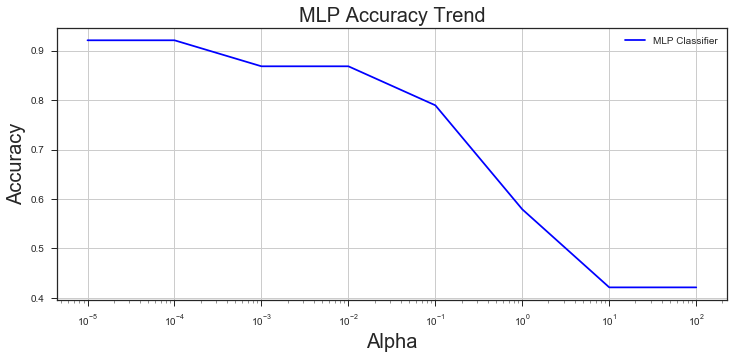

Maximum Accuracy is 0.92105 with 1st Alpha value is 0.00001


In [24]:
parameters = []
accuracies = []

# MLPClassifier
for i in range(-5, 3):
    mlpClf = MLPClassifier(hidden_layer_sizes=(13,), solver='lbfgs', alpha=10**i, random_state=0)
    predYMLP = mlpClf.fit(trainX, trainY.ravel()).predict(testX)
    accuracy = accuracy_score(testY, predYMLP)
    
    parameters.append(mlpClf.alpha)
    accuracies.append(accuracy)

# plot
plt.figure(figsize = (12, 5))
plt.plot(parameters, accuracies, color="blue", label="MLP Classifier")
plt.xscale("log")
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("MLP Accuracy Trend", fontsize = 20)
plt.legend(loc="upper right")

plt.grid(True)
plt.show()

print("Maximum Accuracy is %0.5f" % max(accuracies), "with 1st Alpha value is %0.5f" % 
      parameters[min([i for i, j in zip(count(), accuracies) if j == max(accuracies)])])

Accuracy reach maximum value which is 0.9210 when alpha = 0.00001 and hidden laye = 13.

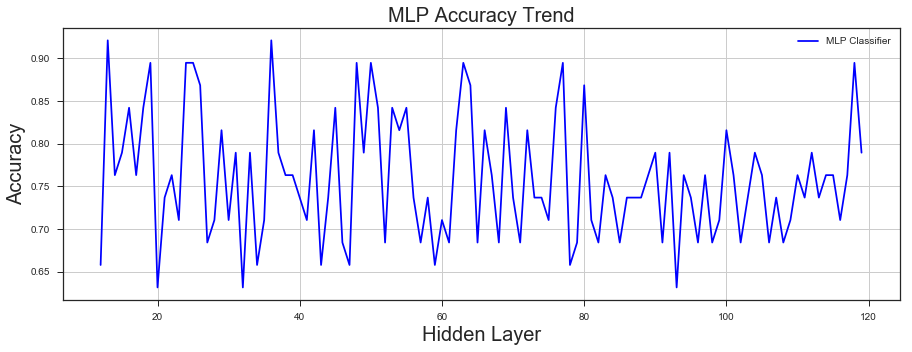

In [25]:
parametersH = []
accuraciesH = []

for h in range(12, 120):
    mlpClf = MLPClassifier(hidden_layer_sizes=(h,), solver='lbfgs', alpha=10**-5, random_state=0)
    predYMLP = mlpClf.fit(trainX, trainY.ravel()).predict(testX)
    accuracy = accuracy_score(testY, predYMLP)
    
    parametersH.append(mlpClf.hidden_layer_sizes)
    accuraciesH.append(accuracy)

    # plot
plt.figure(figsize = (15, 5))
plt.plot(parametersH, accuraciesH, color="blue", label="MLP Classifier")
plt.xlabel("Hidden Layer", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("MLP Accuracy Trend", fontsize = 20)
plt.legend(loc="upper right")

plt.grid(True)
plt.show()

When hiden layer = 13 or 36, accuracy can reach peak = 0.92105.

In [26]:
# alpha=0.00001, hidden_layer_sizes=13
mlpClf = MLPClassifier(hidden_layer_sizes=(13), solver='lbfgs', alpha=10**-5, random_state=0).fit(trainX, trainY.ravel())
predYMLP = mlpClf.predict(testX)
accuracy = accuracy_score(testY, predYMLP)

precisionMLP = precision_score(testY, predYMLP, average='macro')
recallMLP = recall_score(testY, predYMLP, average='macro')
F1ScoreMLP = 2 / ((1 / precisionMLP) + (1 / recallMLP))

print("Accuracy of MLP: %0.4f" % accuracy)
print("\nF-measure for MLP:")
print("Precision:", precisionMLP,"\nRecall:", recallMLP, "\nF1 score:", F1ScoreMLP)

Accuracy of MLP: 0.9211

F-measure for MLP:
Precision: 0.9155844155844157 
Recall: 0.9375 
F1 score: 0.9264126149802892


Accuracy for MLP:

| classifier | Accuracy        | 
|:---------  | :-------------  |
|MLP         | 0.9211          |

For Parameters:

| Parameters          | Set                  | Description                                                        |
|:---------           | :-------------       |:-------------                                                      |
|hidden_layer_sizes   | 13                   | hidden layer size in ith                                           |
|activation           | default = "relu"     | Activation function                                                |
|solver               | lbfgs                | for weight optimization; for small datasets, ‘lbfgs’ is better.    |
|alpha                | 0.00001              | L2 penalty parameter                                               |
|batch_size           | default = "auto"     | Size of minibatches                                                |
|learning_rate        | default = "constant" | For weight updates                                                 |
|learning_rate_init   | default = 0.001      | Initial value of learning rate                                     |
|power_t              | default = 0.5        | Inverse scaling learning rate                                      | 
|max_iter             | default = 200        | Maximum number of iterations                                       | 
|shuffle              | default = True       | When solver= "sgd" or "adam" only                                  | 
|random_state         | 0                    |  Random number generator                                           | 
|ol                   | default = 1e-4       | Tolerance                                                          | 
|verbose              | default = False      | Whether print progress or not                                      |
|warm_start           | default = False      | Whether to reuse previous solution                                 |
|momentum             | default = 0.9        | For gradient descent update                                        |
|validation_fraction  | default = 0.1        | Proportion of training data as validation                          |
|beta_1               | default = 0.9        | Exponential decay rate (1st moment vector) only when solver=’adam’ |
|beta_2               | default = 0.999      | Exponential decay rate (2nd moment vector) only when solver=’adam’ |
|epsilon              | default = 1e-8       | Numerical stability only when solver=’adam’                        |
|                     |                      | Reference: http://scikit-learn.org/                                |




For F-measure:

| Evaluate  | Value   | 
| : --------- : | : ------ : |
|Precision  | 0.9155  |
|Recall     | 0.9375  |
|F1 score   | 0.9264  |

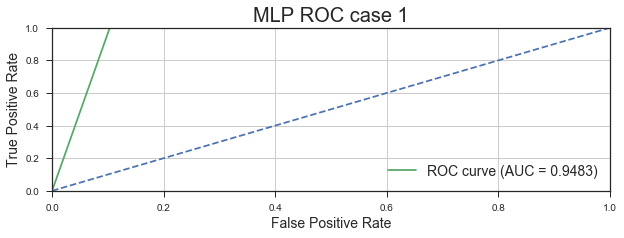

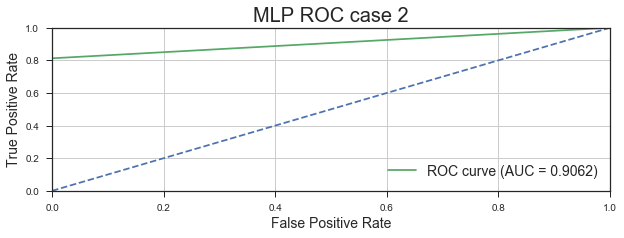

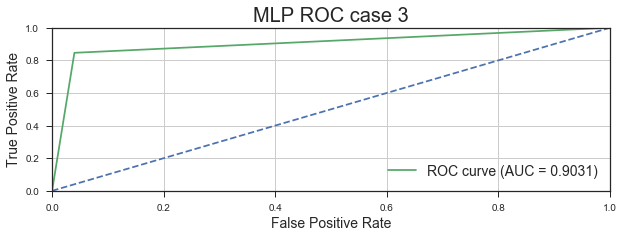

In [27]:
X = trainingX

# binarize
Y = label_binarize(trainingY, classes=[1, 2, 3])

# split data
trainXROC, testXROC, trainYROC, testYROC = train_test_split(X, Y, test_size=0.3, random_state=0)


# MLP classifier
classifierMLP = MLPClassifier(hidden_layer_sizes=(13), solver='lbfgs', alpha=10**-5, random_state=0)

predictedYMLP = dict()

for i in range(3):
    predictedYMLP[i] = classifierMLP.fit(trainXROC, trainYROC[:, i]).predict(testX)

# ROC curve and AUC
falsePositiveR = dict()
truePositiveR = dict()
AUC = dict()

for i in range(3):
    falsePositiveR[i], truePositiveR[i], _ = roc_curve(testYROC[:, i], predictedYMLP[i])


for i in range(3):
    AUC[i] = auc(falsePositiveR[i], truePositiveR[i])

# Plot
for i in range(3):
    plt.figure(figsize = (10, 3))
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(falsePositiveR[i], truePositiveR[i], label='ROC curve (AUC = %0.4f)' % AUC[i])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.title('MLP ROC case %d' %(i+1), fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.legend(loc="lower right", fontsize = 14)
    
    plt.grid(True)
    plt.show()

ROC curve and AUC for each case are shown above when hidden layer = 13 and alpha = 0.00001.

### MLP Summary

| Evaluate     | Value                                         |
|:---------    | :-------------                                |
|Accuracy      | 0.9211 when hiden layer = 13, alpha = 0.00001 |
|Precision     | 0.9155                                        |
|Recall        | 0.9375                                        |
|F1 score      | 0.9264                                        |
|Case 1 AUC    | 0.9483                                        |
|Case 2 AUC    | 0.9062                                        |
|Case 3 AUC    | 0.9031                                        |

### Support Vector Machine

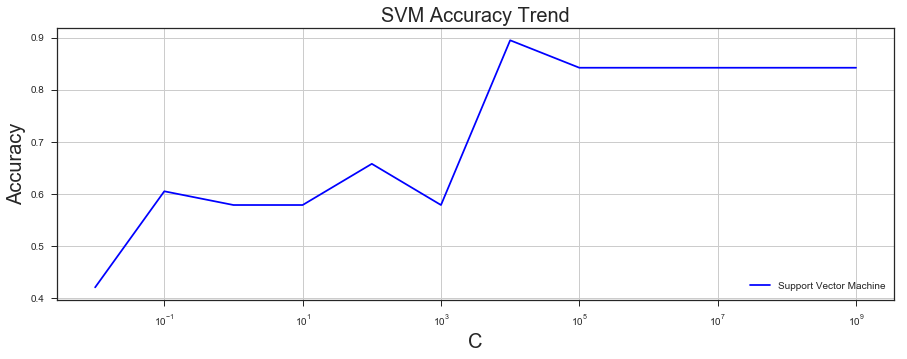

Maximum Accuracy is 0.8947 with 1st C value is 10000.000


In [28]:
parameterSVM = []
accuracySVM = []

# SVM
for i in range(-2, 10):
    svmClf = LinearSVC(C=10**i, random_state=4).fit(trainX,trainY.ravel())
    predYSVM = svmClf.predict(testX)
    
    accuracy = accuracy_score(testY, predYSVM)
    parameterSVM.append(svmClf.C)
    accuracySVM.append(accuracy)
    
# plot
plt.figure(figsize = (15, 5))
plt.plot(parameterSVM,accuracySVM,color='blue', label='Support Vector Machine')
plt.xlabel("C", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("SVM Accuracy Trend", fontsize = 20)
plt.legend(loc="lower right")
plt.xscale('log')

plt.grid(True)
plt.show()


print("Maximum Accuracy is %0.4f" % max(accuracySVM), "with 1st C value is %0.3f" % 
      parameterSVM[min([i for i, j in zip(count(), accuracySVM) if j == max(accuracySVM)])])

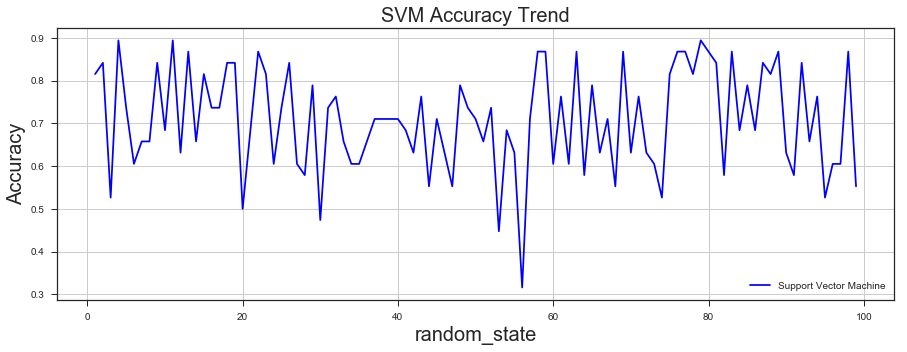

Maximum Accuracy is 0.8947 with 1st random_state value is 4.000


In [29]:
parametersRS = []
accuraciesRS = []

# SVM
for i in range(1, 100):
    svmClf = LinearSVC(C=10000, random_state=i).fit(trainX,trainY.ravel())
    predYSVM = svmClf.predict(testX)
    
    accuracy = accuracy_score(testY, predYSVM)
    parametersRS.append(svmClf.random_state)
    accuraciesRS.append(accuracy)
    
# plot
plt.figure(figsize = (15, 5))
plt.plot(parametersRS, accuraciesRS,color='blue', label='Support Vector Machine')
plt.xlabel("random_state", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("SVM Accuracy Trend", fontsize = 20)
plt.legend(loc="lower right")
# plt.xscale('log')

plt.grid(True)
plt.show()


print("Maximum Accuracy is %0.4f" % max(accuraciesRS), "with 1st random_state value is %0.3f" % 
      parametersRS[min([i for i, j in zip(count(), accuraciesRS) if j == max(accuraciesRS)])])

In [30]:
# C=10000, random_state=4
svmClf4 = LinearSVC(C=10000, random_state=4).fit(trainX, trainY.ravel())
predYSVM4 = svmClf4.predict(testX)
accuracySVM4 = accuracy_score(testY, predYSVM4)

precisionSVM4 = precision_score(testY, predYSVM4, average='macro')
recallSVM4 = recall_score(testY, predYSVM4, average='macro')
F1ScoreSVM4 = 2 / ((1 / precisionSVM4) + (1 / recallSVM4))

print("Accuracy of SVM: %0.4f" % accuracySVM4)
print("\nF-measure for SVM:")
print("Precision:", precisionSVM4,"\nRecall:", recallSVM4, "\nF1 score:", F1ScoreSVM4)

Accuracy of SVM: 0.8947

F-measure for SVM:
Precision: 0.8956552706552706 
Recall: 0.8956552706552706 
F1 score: 0.8956552706552706


Accuracy for SVM:

| classifier | Accuracy                            | 
| ---------  | -------------                       |
|SVM         | 0.8947 when C=10000, random_state=4 |

For Parameters:

| Parameters        | Set                       | Description                                       |
|-------------------|---------------------------|---------------------------------------------------|
|penalty            | default = "l2"            | Norm in the penalization                          |
|loss               | default = "squared_hinge" | loss function                                     |
|dual               | default = 1e-4            | Tolerance for stopping criteria                   |
|tol                | 0.00001                   | L2 penalty parameter                              |
|C                  | 10000                     | Penalty parameter of the error term               |
|multi_class        | default = "ovr"           | multi-class strategy                              |
|fit_intercept      | default = True            | Whether to calculate the intercept for this model |
|intercept_scaling  | default = 1               | a synthetic feature for the instance vector       | 
|class_weight       | default                   | class_weight[i] * C                               | 
|verbose            | default = 0               | verbose output                                    | 
|random_state       | 4                         |  Random number generator                          | 
|max_iter           | default = 1000            | maximum number of iterations                      | 
|                   |                           | Reference: http://scikit-learn.org/               |

For F-measure:

| Evaluate  | Value   | 
| --------- |  ------ |
| Precision | 0.8956  |
| Recall    | 0.8956  |
| F1 score  | 0.8956  |

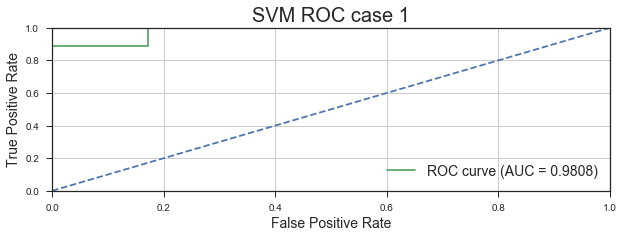

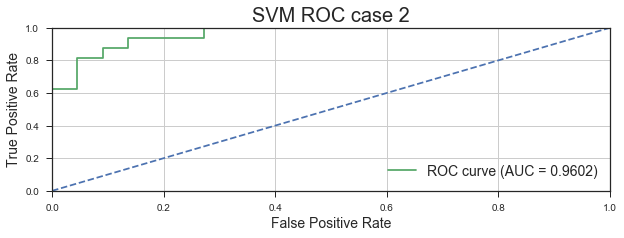

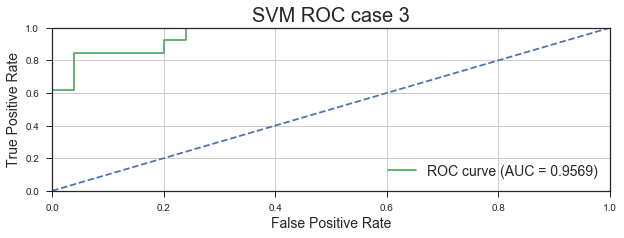

In [31]:
X = trainingX

# binarize
Y = label_binarize(trainingY, classes=[1, 2, 3])

# split data
trainXROC, testXROC, trainYROC, testYROC = train_test_split(X, Y, test_size=0.3, random_state=0)

# SVM classifier
classifierSVM = OneVsRestClassifier(LinearSVC(C=10000, random_state=4))
predictedYSVMROC = classifierSVM.fit(trainXROC, trainYROC).decision_function(testXROC)

# ROC curve and AUC
falsePositiveR = dict()
truePositiveR = dict()
AUC = dict()

for i in range(3):
    falsePositiveR[i], truePositiveR[i], _ = roc_curve(testYROC[:, i], predictedYSVMROC[:, i])
    AUC[i] = auc(falsePositiveR[i], truePositiveR[i])

# Plot
for i in range(3):
    plt.figure(figsize = (10, 3))
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(falsePositiveR[i], truePositiveR[i], label='ROC curve (AUC = %0.4f)' % AUC[i])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.title('SVM ROC case %d' %(i+1), fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.legend(loc="lower right", fontsize = 14)
    
    plt.grid(True)
    plt.show()

ROC curve and AUC for each case are shown above when C = 10000 and random_state = 4.

### SVM Summary

| Evaluate     | Value                                         |
|:--------- | :------------- |
|Accuracy      | 0.8947 when C=10000, random_state=4 |
|Precision     | 0.8956                                        |
|Recall        | 0.8956                                        |
|F1 score      | 0.8956                                        |
|Case 1 AUC    | 0.9808                                        |
|Case 2 AUC    | 0.9602                                        |
|Case 3 AUC    | 0.9569                                        |

### Ensemble Classifier

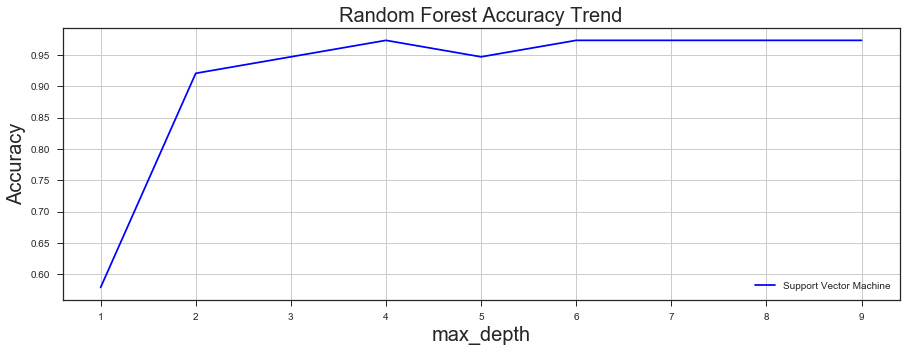

Maximum Accuracy is 0.9737 with 1st max_depth value is 4.000


In [32]:
parameterRF = []
accuracyRF = []

# Random Forest
for i in range(1, 10):
    rfClf = RandomForestClassifier(max_depth=i, random_state=0).fit(trainX,trainY.ravel())
    predYRF = rfClf.predict(testX)
    
    accuracy = accuracy_score(testY, predYRF)
    parameterRF.append(rfClf.max_depth)
    accuracyRF.append(accuracy)
    
# plot
plt.figure(figsize = (15, 5))
plt.plot(parameterRF ,accuracyRF ,color='blue', label='Support Vector Machine')
plt.xlabel("max_depth", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Random Forest Accuracy Trend", fontsize = 20)
plt.legend(loc="lower right")
# plt.xscale('log')

plt.grid(True)
plt.show()


print("Maximum Accuracy is %0.4f" % max(accuracyRF), "with 1st max_depth value is %0.3f" % 
      parameterRF[min([i for i, j in zip(count(), accuracyRF) if j == max(accuracyRF)])])

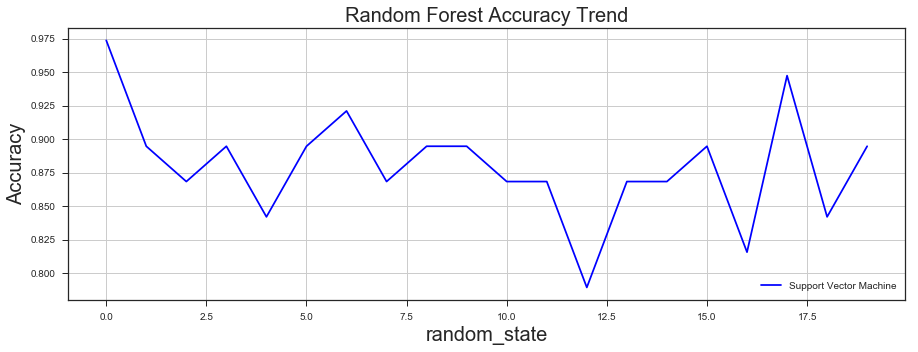

Maximum Accuracy is 0.9737 with 1st random_state value is 0.000


In [33]:
parametersRFRS = []
accuraciesRFRS = []

# Random Forest
for i in range(0, 20):
    rfClf = RandomForestClassifier(max_depth=4, random_state=i).fit(trainX,trainY.ravel())
    predYSVM = rfClf.predict(testX)
    
    accuracy = accuracy_score(testY, predYSVM)
    parametersRFRS.append(rfClf.random_state)
    accuraciesRFRS.append(accuracy)
    
# plot
plt.figure(figsize = (15, 5))
plt.plot(parametersRFRS, accuraciesRFRS,color='blue', label='Support Vector Machine')
plt.xlabel("random_state", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Random Forest Accuracy Trend", fontsize = 20)
plt.legend(loc="lower right")
# plt.xscale('log')

plt.grid(True)
plt.show()


print("Maximum Accuracy is %0.4f" % max(accuraciesRFRS), "with 1st random_state value is %0.3f" % 
      parametersRFRS[min([i for i, j in zip(count(), accuraciesRFRS) if j == max(accuraciesRFRS)])])

In [34]:
# max_depth=4, random_state=0
rfClf4 = RandomForestClassifier(max_depth=4, random_state=0).fit(trainX,trainY.ravel())
predYRF4 = rfClf4.predict(testX)
accuracyRF4 = accuracy_score(testY, predYRF4)

precisionRF4 = precision_score(testY, predYRF4, average='macro')
recallRF4 = recall_score(testY, predYRF4, average='macro')
F1ScoreRF4 = 2 / ((1 / precisionRF4) + (1 / recallRF4))

print("Accuracy of Random Forest: %0.4f" % accuracyRF4)
print("\nF-measure for Random Forest:")
print("Precision:", precisionRF4,"\nRecall:", recallRF4, "\nF1 score:", F1ScoreRF4)

Accuracy of Random Forest: 0.9737

F-measure for Random Forest:
Precision: 0.9666666666666667 
Recall: 0.9791666666666666 
F1 score: 0.9728765167737329


Accuracy for Random Forest:

| classifier | Accuracy                            | 
|---------|-------------|
|Random Forest | 0.9737 when max_depth=4, random_state=0 |

For Parameters:

| Parameters              | Set                       | Description                                |
|-------------------      |-------------------|--------------------------------------------------- |
|n_estimators             | default = 10      | Number of trees                                    |
|criterion                | default = "gini"  | To measure the quality of a split                  |
|max_features             | default = "auto"  | The number for the best split                      |
|max_depth                | 4                 | maximum depth                                      |
|min_samples_split        | default = 2       | minimum number to split an internal node           |
|min_samples_leaf         | default=1         | minimum number for a leaf node                     |
|min_weight_fraction_leaf | default = 0       | minimum weighted fraction                          |
|max_leaf_nodes           | default = None    | maximum number of leaf nodes                       | 
|min_impurity_decrease    | default = 0       | minimun value of decrease of the impurity to split | 
|bootstrap                | default = True    | To build tree                                      | 
|oob_score                | default = False   | Whether to use out-of-bag samples                  | 
|n_jobs                   | default = 1       | Number of parallel jobs                            | 
|random_state             | 0                 |  Random number generator                           |
|verbose                  | default = 0       |  verbosity                                         |
|warm_start               | default = False   |  Whether to reuse the previous solution            |         
|class_weight             | default=None      |  Weights associated with classes                   | 
|                         |                   | Reference: http://scikit-learn.org/                |

For F-measure:

| Evaluate  | Value   | 
| --------- |  ------ |
| Precision | 0.9666  |
| Recall    | 0.9791  |
| F1 score  | 0.9728  |

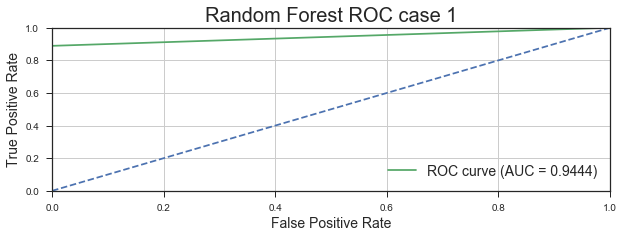

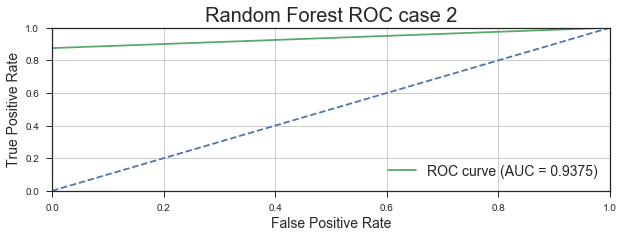

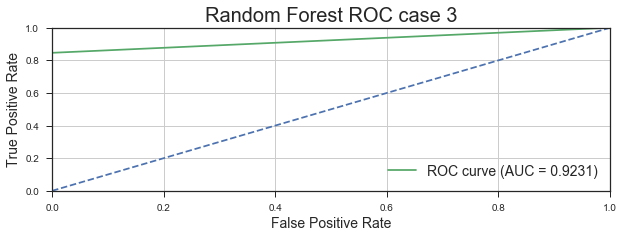

In [35]:
X = trainingX

# binarize
Y = label_binarize(trainingY, classes=[1, 2, 3])

# split data
trainXROC, testXROC, trainYROC, testYROC = train_test_split(X, Y, test_size=0.3, random_state=0)

# Random Forest classifier
classifierRF = RandomForestClassifier(max_depth=4, random_state=0)
predictedYRFROC = classifierRF.fit(trainXROC, trainYROC).predict(testXROC)

# ROC curve and AUC
falsePositiveR = dict()
truePositiveR = dict()
AUC = dict()

for i in range(3):
    falsePositiveR[i], truePositiveR[i], _ = roc_curve(testYROC[:, i], predictedYRFROC[:, i])
    AUC[i] = auc(falsePositiveR[i], truePositiveR[i])

# Plot
for i in range(3):
    plt.figure(figsize = (10, 3))
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(falsePositiveR[i], truePositiveR[i], label='ROC curve (AUC = %0.4f)' % AUC[i])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.title('Random Forest ROC case %d' %(i+1), fontsize = 20)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.legend(loc="lower right", fontsize = 14)
    
    plt.grid(True)
    plt.show()

ROC curve and AUC for each case are shown above when max_depth = 4, random_state = 0.

### Random Forest Summary

| Evaluate     | Value                                         |
|:--------- | :------------- |
|Accuracy      | 0.9737 when max_depth=4, random_state=0 |
|Precision     | 0.9666                                        |
|Recall        | 0.9791                                        |
|F1 score      | 0.9728                                        |
|Case 1 AUC    | 0.9444                                        |
|Case 2 AUC    | 0.9375                                        |
|Case 3 AUC    | 0.9231                                        |

### Classifiers Summary

| Evaluate/Clf | kNN          |Decision Tree |MLP           |Naïve Bayes | SVM            | Random Forest      |
|:---------    | :------------|:-------------|:-------------|:-----------|:-----          |:-----              |
|Accuracy      | 0.7105 (k=5) |0.8947 (Gini) |0.9211 (HL=13)|0.8947      |0.8947 (C=10000)|0.9737 (max_depth=4)|
|Precision     | 0.7142       |0.8952        |0.9155        |0.8857      |0.8956          |0.9666              |
|Recall        | 0.7516       |0.9118        |0.9375        |0.9004      |0.8956          |0.9791              |
|F1 score      | 0.7324       |0.9034        |0.9264        |0.8930      |0.8956          |0.9728              |
|Case 1 AUC    | 0.9272       |0.9828        |0.9483        |0.9272      |0.9808          |0.9444              |
|Case 2 AUC    | 0.6506       |0.8835        |0.9062        |0.9062      |0.9602          |0.9375              |
|Case 3 AUC    | 0.7462       |0.9215        |0.9031        |0.9415      |0.9569          |0.9231              |

According to the comparsion table shown above, I prefer Random Forest Classifier (Ensemble Classifier) with max_depth = 4 and random_state = 0 because it has the highest accuracy in training set and it also has good performance in F-measure.

Ensemble Classifier (Random Forest Classifier in this lab) is a fast classifier in training and has a strong performane in predicting results. Morover, it has other advantages such as overfitting reduction. However, it has some limitation. For example, its speed in predicting results is slower than other classifiers becasues for pursuing high accuracy, it has to build more trees.



## Make predictions and evaluate performance on the test set

### k-Nearest Neighbors

In [36]:
kNNpredictedValY = wineKnnClf.predict(validationX)
kNNscoreVal = accuracy_score(validationY, kNNpredictedValY)

kNNprecision = precision_score(validationY, kNNpredictedValY, average='macro')
kNNrecall = recall_score(validationY, kNNpredictedValY, average='macro')
kNNF1Score = 2 / ((1 / kNNprecision) + (1 / kNNrecall))

print("Accuracy of kNN: %0.4f" % kNNscoreVal)
print("\nF-measure for kNN:")
print("Precision:", kNNprecision,"\nRecall:", kNNrecall, "\nF1 score:", kNNF1Score)

Accuracy of kNN: 0.7407

F-measure for kNN:
Precision: 0.7257631257631258 
Recall: 0.7282542019384124 
F1 score: 0.727006529948926


### Decision Tree

In [37]:
DTpredictedValY = DecisionTreeGini.predict(validationX)
DTscoreVal = accuracy_score(validationY, DTpredictedValY)

DTprecision = precision_score(validationY, DTpredictedValY, average='macro')
DTrecall = recall_score(validationY, DTpredictedValY, average='macro')
DTF1Score = 2 / ((1 / DTprecision) + (1 / DTrecall))

print("Accuracy of Decision Tree: %0.4f" % DTscoreVal)
print("\nF-measure for Decision Tree:")
print("Precision:", DTprecision,"\nRecall:", DTrecall, "\nF1 score:", DTF1Score)

Accuracy of Decision Tree: 0.9630

F-measure for Decision Tree:
Precision: 0.9576923076923077 
Recall: 0.9592074592074592 
F1 score: 0.9584492846485916


### Naïve Bayes

In [38]:
NBpredictedValY = NBClf.predict(validationX)
NBscoreVal = accuracy_score(validationY, NBpredictedValY)

NBprecision = precision_score(validationY, NBpredictedValY, average='macro')
NBrecall = recall_score(validationY, NBpredictedValY, average='macro')
NBF1Score = 2 / ((1 / NBprecision) + (1 / NBrecall))

print("Accuracy of Naïve Bayes: %0.4f" % NBscoreVal)
print("\nF-measure for Naïve Bayes:")
print("Precision:", NBprecision,"\nRecall:", NBrecall, "\nF1 score:", NBF1Score)

Accuracy of Naïve Bayes: 0.9259

F-measure for Naïve Bayes:
Precision: 0.9273689273689273 
Recall: 0.934609250398724 
F1 score: 0.9309750118451681


### Artificial Neural Network

In [39]:
MLPpredictedValY = mlpClf.predict(validationX)
MLPscoreVal = accuracy_score(validationY, MLPpredictedValY)

MLPprecision = precision_score(validationY, MLPpredictedValY, average='macro')
MLPrecall = recall_score(validationY, MLPpredictedValY, average='macro')
MLPF1Score = 2 / ((1 / MLPprecision) + (1 / MLPrecall))

print("Accuracy of MLP: %0.4f" % MLPscoreVal)
print("\nF-measure for MLP:")
print("Precision:", MLPprecision,"\nRecall:", MLPrecall, "\nF1 score:", MLPF1Score)

Accuracy of MLP: 0.9259

F-measure for MLP:
Precision: 0.9208333333333334 
Recall: 0.9370015948963317 
F1 score: 0.9288471099950997


### Support Vector Machine 

In [40]:
SVMpredictedValY = svmClf4.predict(validationX)
SVMscoreVal = accuracy_score(validationY, SVMpredictedValY)

SVMprecision = precision_score(validationY, SVMpredictedValY, average='macro')
SVMrecall = recall_score(validationY, SVMpredictedValY, average='macro')
SVMF1Score = 2 / ((1 / SVMprecision) + (1 / SVMrecall))

print("Accuracy of SVM: %0.4f" % SVMscoreVal)
print("\nF-measure for SVM:")
print("Precision:", SVMprecision,"\nRecall:", SVMrecall, "\nF1 score:", SVMF1Score)

Accuracy of SVM: 0.9444

F-measure for SVM:
Precision: 0.9524959742351046 
Recall: 0.9497607655502392 
F1 score: 0.9511264034476614


### Ensemble Classifier

In [41]:
RFpredictedValY = rfClf4.predict(validationX)
RFscoreVal = accuracy_score(validationY, RFpredictedValY)

RFprecision = precision_score(validationY, RFpredictedValY, average='macro')
RFrecall = recall_score(validationY, RFpredictedValY, average='macro')
RFF1Score = 2 / ((1 / RFprecision) + (1 / RFrecall))

print("Accuracy of Random Forests: %0.4f" % RFscoreVal)
print("\nF-measure for Random Forests:")
print("Precision:", RFprecision,"\nRecall:", RFrecall, "\nF1 score:", RFF1Score)

Accuracy of Random Forests: 0.9444

F-measure for Random Forests:
Precision: 0.9427736006683375 
Recall: 0.9521531100478469 
F1 score: 0.9474401420074906


### Summary of prediction on the test set

| Clf/Accuracy  | Training                             | Test    |            
|:---------     | :------------                        |:--------|         
|kNN            | 0.7105 (k=5)                         |0.7407   |
|Decision Tree  | 0.8947 (Gini); 0.8158 (Entropy)      |0.9630   |    
|MLP            | 0.9211 (HL=13, alpha=0.00001)        |0.9259   |       
|Naïve Bayes    | 0.8947                               |0.9259   |          
|SVM            | 0.8947 (C=10000, random_state=4)     |0.9444   |        
|Random Forest  | 0.9737 (max_depth=4, random_state=0) |0.9444   |

kNN classifie, Random Forests Classifier and MLP classifier generate comparable accuracy with that on training set although the accuracy of Random Forests Classifier is slightly lower than that on its training set (0.9737 v.s. 0.9444).

Decision Tree, Naïve Bayes and SVM classifiers generate higher accuracy with that on training set so they might be under-fitting on training process.


## Exceptional work

I choose GridSearchCV to get parameters for SVM becasue it takes some time in previous task to tune the parameters of SVM.

In [42]:
tuned_parameters = [{'random_state': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'C': [1, 10, 100, 1000, 10000, 100000]}]

clfGrid = GridSearchCV(LinearSVC(), tuned_parameters, cv=5, return_train_score=False)
clfGrid.fit(trainingX, trainingY.ravel())
cv_results = pd.DataFrame(clfGrid.cv_results_).sort_values(by="rank_test_score")
cv_results = cv_results.drop(["mean_fit_time", "mean_score_time", "params",
                "rank_test_score", "split0_test_score", "split1_test_score", "split2_test_score", 
                 "split3_test_score", "split4_test_score", "std_fit_time", "std_score_time", "std_test_score"], axis=1)

best = clfGrid.best_estimator_
print(best)

cv_results.head()

LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=4, tol=0.0001,
     verbose=0)


,mean_test_score,param_C,param_random_state
34,0.895161,1000,4
52,0.870968,100000,2
47,0.822581,10000,7
42,0.806452,10000,2
32,0.806452,1000,2


Best parameters are shown above.

The table above shows the rank of parameters searching by grid search.

In [43]:
predYSVCGrid= clfGrid.predict(testX)

accuracySVCGrid = accuracy_score(testY, predYSVCGrid)
precisionSVCGrid = precision_score(testY, predYSVCGrid, average='macro')
recallSVCGrid = recall_score(testY, predYSVCGrid, average='macro')
F1ScoreSVCGrid = 2 / ((1 / precisionSVCGrid) + (1 / recallSVCGrid))

print("Accuracy of SVM with grid search in training set: %0.4f" % accuracySVCGrid)
print("\nF-measure for SVM with grid search in training set:")
print("Precision:", precisionSVCGrid,"\nRecall:", recallSVCGrid, "\nF1 score:", F1ScoreSVCGrid)

Accuracy of SVM with grid search in training set: 0.8684

F-measure for SVM with grid search in training set:
Precision: 0.8928571428571429 
Recall: 0.8748219373219372 
F1 score: 0.8837475356520987


In [44]:
SVMGridpredictedValY = clfGrid.predict(validationX)
SVMGridscoreVal = accuracy_score(validationY, SVMGridpredictedValY)

SVMGridprecision = precision_score(validationY, SVMGridpredictedValY, average='macro')
SVMGridrecall = recall_score(validationY, SVMGridpredictedValY, average='macro')
SVMGridF1Score = 2 / ((1 / SVMGridprecision) + (1 / SVMGridrecall))

print("Accuracy of SVM with grid search in validation set: %0.4f" % SVMGridscoreVal)
print("\nF-measure for SVM with grid search in validation set:")
print("Precision:", SVMGridprecision,"\nRecall:", SVMGridrecall, "\nF1 score:", SVMGridF1Score)

Accuracy of SVM with grid search in validation set: 0.8333

F-measure for SVM with grid search in validation set:
Precision: 0.8441176470588235 
Recall: 0.8564593301435407 
F1 score: 0.8502437046415598


In [45]:
svmClfdefault = LinearSVC().fit(trainX, trainY.ravel())
predYSVMdefault = svmClfdefault.predict(testX)
accuracySVMdefault = accuracy_score(testY, predYSVMdefault)

SVMDefaultPredictedValY = svmClfdefault.predict(validationX)
SVMDefaultScoreVal = accuracy_score(validationY, SVMDefaultPredictedValY)

print("Accuracy of SVM with default parameters in training set: %0.4f" % accuracySVMdefault)
print("Accuracy of SVM with default parameters in validation set: %0.4f" % SVMDefaultScoreVal)

Accuracy of SVM with default parameters in training set: 0.5789
Accuracy of SVM with default parameters in validation set: 0.6481


Accuracy of SVM with default parameters is shown above.

### Summary of w/o grid search

| Clf/Accuracy                   | Training                           | Validation |            
|:---------                      | :------------                      |:--------   |                 
|SVM with hand-tuned parameters  | 0.8947 (C=10000, random_state=4)   |0.9444      |        
|SVM with grid search            | 0.8684 (C=1000, random_state=4)    |0.8333      |
|SVM with default parameters     | 0.5789 (default parameters)        |0.6481      |

According to the table above, on training set, the accuracy of SVM with grid search is 0.8684 which is slightly lower than previous accuracy, 0.8947. On validation set, the accuracy of SVM with grid search is 0.8333 which is much lower than 0.9444 which is the accuracy without grid search.

Although on validation, SVM with grid search has lower accuracy but the parameters of SVM without grid search is hand-tuned so it take a great deal of time. Moreover, without hand-tuned parameters, the accuracy of SVM with defualt parameters is bad.

Therefore, grid search is useful becasue it could save time and generate parameters to get comparable accuracy. 